<a href="https://colab.research.google.com/github/healthonrails/annolid/blob/main/docs/tutorials/Annolid_on_Detectron2_Tutorial.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Annolid on Detectron2 Tutorial 1 : Introduction to Detectron2

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to Annolid on detectron2! This is modified from the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
# Is running in colab or in jupyter-notebook
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

You should consider upgrading via the '/Users/chenyang/miniconda3/envs/ceed/bin/python -m pip install --upgrade pip' command.


torch:  1.9 ; cuda:  1.9.0


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/1.9.0/torch1.9/index.html


You should consider upgrading via the '/Users/chenyang/miniconda3/envs/ceed/bin/python -m pip install --upgrade pip' command.


In [3]:
# import some common libraries
import json
import os
import cv2
import random
import glob
import numpy as np
if IN_COLAB:
  from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


In [5]:
# is there a gpu
if torch.cuda.is_available():
    GPU = True
    print('gpu available')
else:
    GPU = False
    print('no gpu')

no gpu


## Upload a labeled dataset.
The following code is expecting the dataset in the COCO format to be in a ***.zip*** file. For example: ```sample_dataset.zip``` \


In [6]:
!pip install gdown 
!gdown --id 1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR

You should consider upgrading via the '/Users/chenyang/miniconda3/envs/ceed/bin/python -m pip install --upgrade pip' command.


Downloading...
From: https://drive.google.com/uc?id=1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR
To: /Users/chenyang/Desktop/Developer/cpl/annolid/book/tutorials/novelctrlk6_8_coco_dataset.zip


  0%|                                               | 0.00/10.3M [00:00<?, ?B/s]

  5%|█▉                                     | 524k/10.3M [00:00<00:02, 4.10MB/s]

 15%|█████▊                                | 1.57M/10.3M [00:00<00:01, 4.72MB/s]

 36%|█████████████▌                        | 3.67M/10.3M [00:00<00:01, 5.88MB/s]

 56%|█████████████████████▎                | 5.77M/10.3M [00:00<00:00, 7.32MB/s]

 76%|████████████████████████████▉         | 7.86M/10.3M [00:00<00:00, 8.94MB/s]

100%|██████████████████████████████████████| 10.3M/10.3M [00:00<00:00, 12.9MB/s]


In [7]:
if IN_COLAB:
    dataset = '/content/novelctrlk6_8_coco_dataset.zip'
else:
    dataset = 'novelctrlk6_8_coco_dataset.zip'

### Note1: If you want to use your own dataset instead of the demo one, please uncomment and edit the following code.

### Note2: please make sure there is no white space in your file path if you encounter file not found issues.

In [8]:
# if IN_COLAB:
#     from google.colab import files
#     uploaded = files.upload()
# else:
#     from ipywidgets import FileUpload
#     from IPython.display import display
#     !jupyter nbextension enable --py widgetsnbextension
#     uploaded = FileUpload()

# display(uploaded)

In [9]:
# if IN_COLAB:
#     dataset =  list(uploaded.keys())[0]
# else:
#     dataset = list(uploaded.value.keys())[0]


If your dataset has the same name as the file you uploaded, you do not need to manually input the name (just run the next cells). **Otherwise, you need to replace DATASET_NAME and DATASET_DIR with your own strings like `DATASET_NAME = "NameOfMyDataset"` and `DATASETDIR="NameOfMyDatasetDirectory"`**. To do that, uncomment the commented out cell below and replace the strings with the appropriate names

In [10]:
# DATASET_NAME = 'NameOfMyDataset' 
# DATASET_DIR = 'NameOfMyDatasetDirectory'

In [11]:
if IN_COLAB:
    !unzip $dataset -d /content/
else:
    !unzip -o $dataset -d .

Archive:  novelctrlk6_8_coco_dataset.zip
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001416_41.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004233_81.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004515_22.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000636_6.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006297_11.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006818_79.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006056_25.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006094_12.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004340_96.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000557_50.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000979_94.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005018_19.jpg  
  inflating: ./novelctrlk6_8_coco_da

  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004335_26.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004804_39.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006396_43.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006993_65.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000865_92.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003114_35.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001918_2.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004935_56.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006959_78.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005216_14.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003092_22.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001528_44.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003208_12.jpg  



  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001476_48.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004555_67.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003070_62.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005007_38.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003342_41.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00002267_91.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00002248_99.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000702_46.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003237_15.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00002412_96.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001322_73.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00002328_97.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004312_85.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004443_46.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003783_81.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000779_3.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00002654_1.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004685_90.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004098_59.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006538_99.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006832_71.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00007024_26.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005772_51.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006330_76.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000871_10.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00003034_64.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004539_89.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005788_49.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/annotations.json  


  inflating: ./novelctrlk6_8_coco_dataset/.DS_Store  
  inflating: ./__MACOSX/novelctrlk6_8_coco_dataset/._.DS_Store  
  inflating: ./novelctrlk6_8_coco_dataset/data.yaml  
  inflating: ./novelctrlk6_8_coco_dataset/train/.DS_Store  
  inflating: ./__MACOSX/novelctrlk6_8_coco_dataset/train/._.DS_Store  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001466_29.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006804_57.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00007044_50.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006232_55.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000759_28.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003680_32.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004441_88.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005090_94.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002476_27.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000965_42.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001652_55.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002000_18.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002333_0.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005752_39.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006670_0.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005763_18.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004469_75.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005566_43.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004336_74.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006574_88.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001922_1.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001795_5.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005755_34.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003576_54.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002647_78.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004295_47.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003667_56.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006131_85.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000311_77.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000879_40.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002991_7.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000757_5.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004628_68.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004348_33.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003269_66.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003224_49.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002628_21.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001838_25.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002825_40.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002247_29.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003100_30.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001922_57.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001320_92.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006299_63.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000952_60.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000842_70.jpg  
  inflating: ./__MACOSX/novelctrlk6_8_coco_dataset/train/JPEGImages/._00000842_70.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002295_32.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004117_59.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003976_44.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004032_20.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006212_69.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003134_31.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006169_98.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006830_36.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004570_24.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000735_23.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003905_42.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003012_37.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005456_95.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002456_9.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002433_90.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006715_97.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005597_15.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006319_53.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005025_83.jpg  

  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002362_63.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002311_72.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005068_37.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006353_11.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005056_91.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000970_34.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002577_24.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006601_16.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000652_65.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002639_95.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005953_8.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006000_27.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005700_89.jpg  



  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005154_53.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005584_93.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003834_80.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004711_6.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006038_20.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006373_2.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006470_84.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003956_16.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002625_79.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006270_45.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006521_86.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001999_45.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004081_4.jpg  
 


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002546_58.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001181_61.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002226_87.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001632_33.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006218_71.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00005400_9.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001299_86.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002067_75.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006844_69.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001892_72.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001153_93.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001389_82.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001439_52.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006367_98.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004018_67.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004535_48.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006361_13.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003167_10.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006832_66.jpg  


  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004956_38.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00001980_61.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003364_13.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/annotations.json  


In [12]:
DATASET_NAME = DATASET_DIR = f"{dataset.replace('.zip','')}"

# Run a pre-trained detectron2 model

First, we check a random selected image from our training dataset:

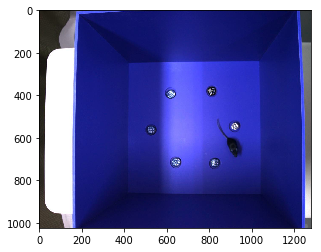

In [13]:
# select and display one random image from the training set
img_file = random.choice(glob.glob(f"{DATASET_DIR}/train/JPEGImages/*.*"))
im = cv2.imread(img_file)
if IN_COLAB:
    cv2_imshow(im)
else:
    plt.imshow(im)

Then, we create a Detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [14]:
cfg = get_cfg()

In [15]:
if GPU:
    pass
else:
    cfg.MODEL.DEVICE='cpu'

In [16]:
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set threshold for this model
# Find a model from Detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/Users/chenyang/miniconda3/envs/ceed/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


/Users/chenyang/miniconda3/envs/ceed/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [17]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([74, 74, 65,  6, 74, 56])
Boxes(tensor([[ 791.9539,  358.5143,  835.7755,  403.3139],
        [ 502.8876,  541.0079,  552.8179,  588.6618],
        [  19.6670,  156.9238,  165.2130,  984.5294],
        [  45.9373,    8.8360, 1280.0000,  983.8845],
        [ 595.6891,  372.0525,  644.3878,  414.5810],
        [  10.1923,   61.7742,  166.9124,  970.0615]]))


In [18]:
outputs['instances'].pred_masks

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [19]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

Metadata(evaluator_type='coco', image_root='datasets/coco/train2017', json_file='datasets/coco/annotations/instances_train2017.json', name='coco_2017_train', thing_classes=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy b

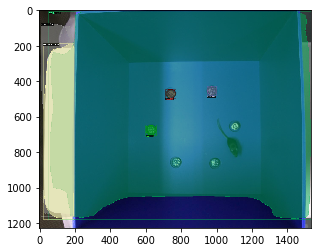

In [20]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
if IN_COLAB:
    cv2_imshow(out.get_image()[:, :, ::-1])
else:
    plt.imshow(out.get_image()[:, :, ::-1])

As we can see, the network doesn't detect what we want. That is expected as we have not fine-tuned the network with our custom dataset. We are going to do that in the next steps.